## 1. Is it the amplitude? Testing out a single LIF neuron

### 1.1 Plotting sub threshold amplitude (= 300.6) with two stimulation times

- based on the plots, the behaviour looks normal. The voltage increases up to about -52 mV but remains below threshold.
- for both a stimulation time of 100 and 150 ms. 

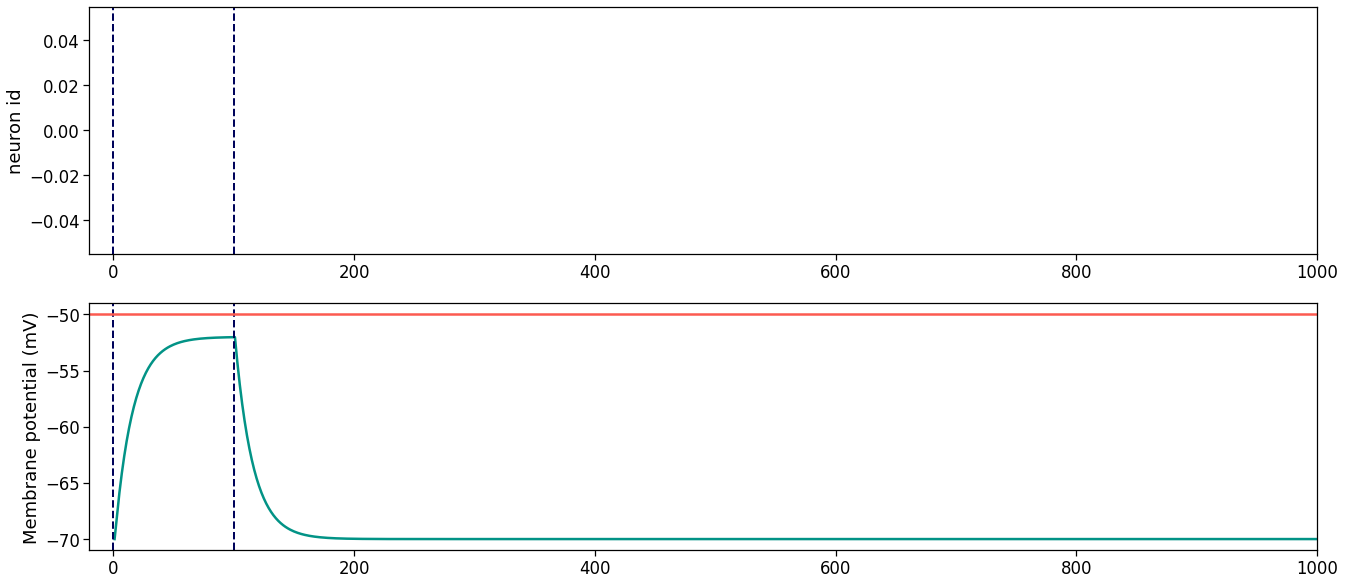

In [10]:
single_lif_neuron(300.6, 100., model_params)

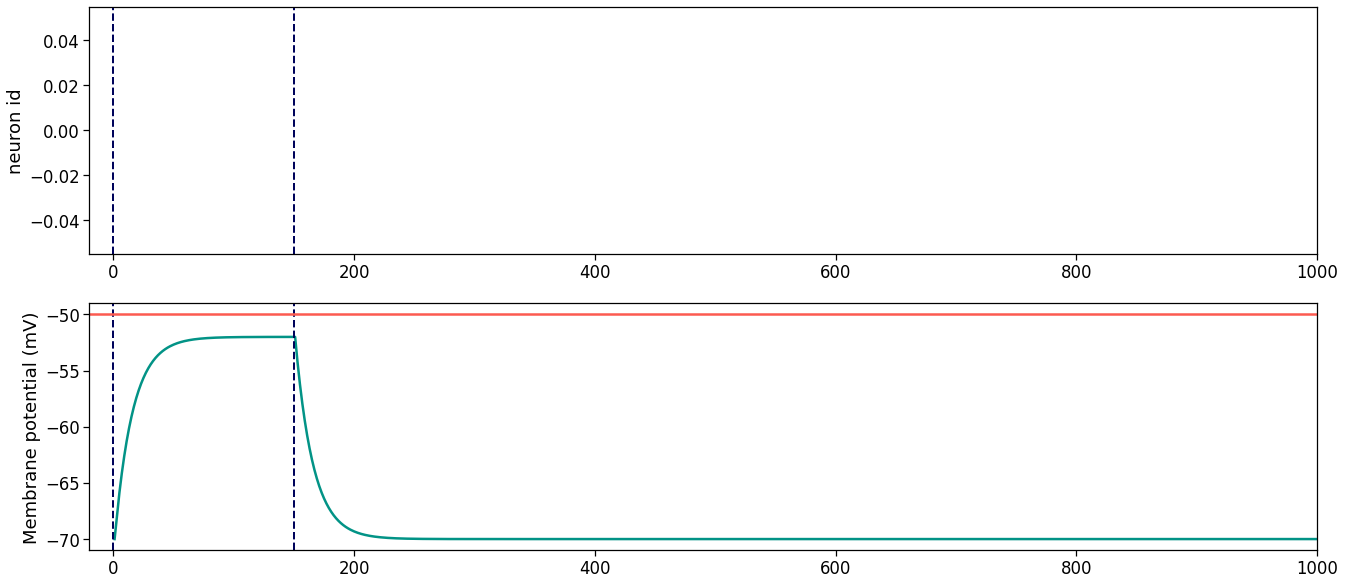

In [11]:
single_lif_neuron(300.6, 150., model_params)

### 1.2 Plotting supra threshold amplitude (= 337.34) with two stimulation times

- The neuron spikes once for 100 ms and twice for 150 ms. There is a spike exactly where the voltage crosses the threshold. 

Conclusion: the amplitudes seem to be fine.

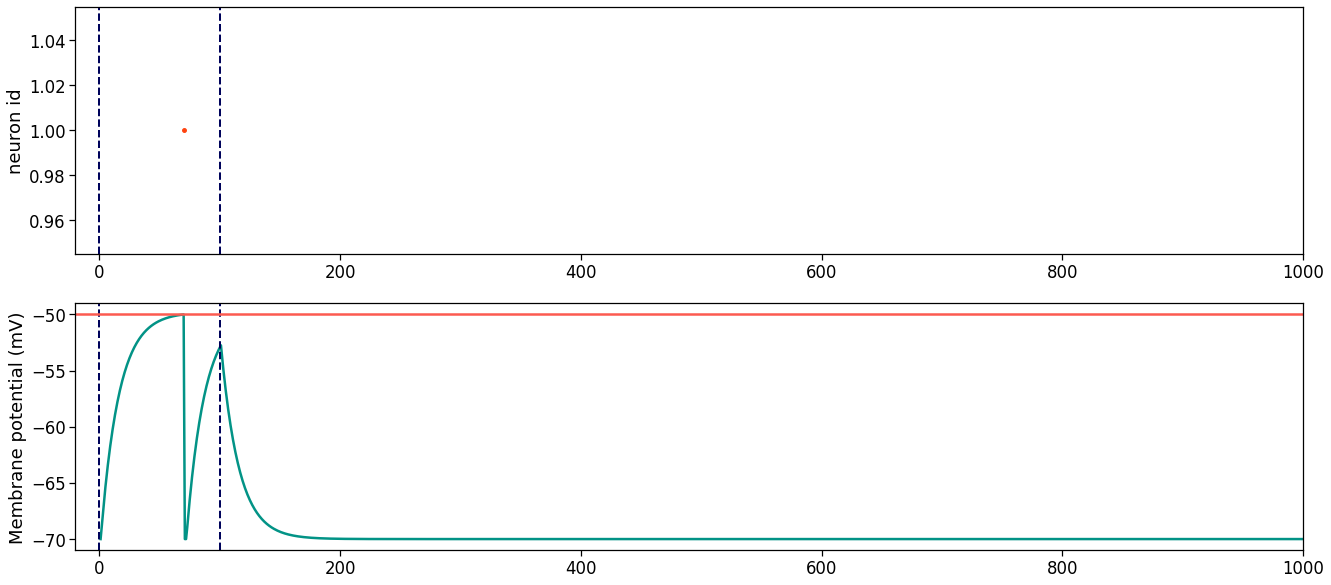

In [12]:
single_lif_neuron(337.34, 100., model_params)

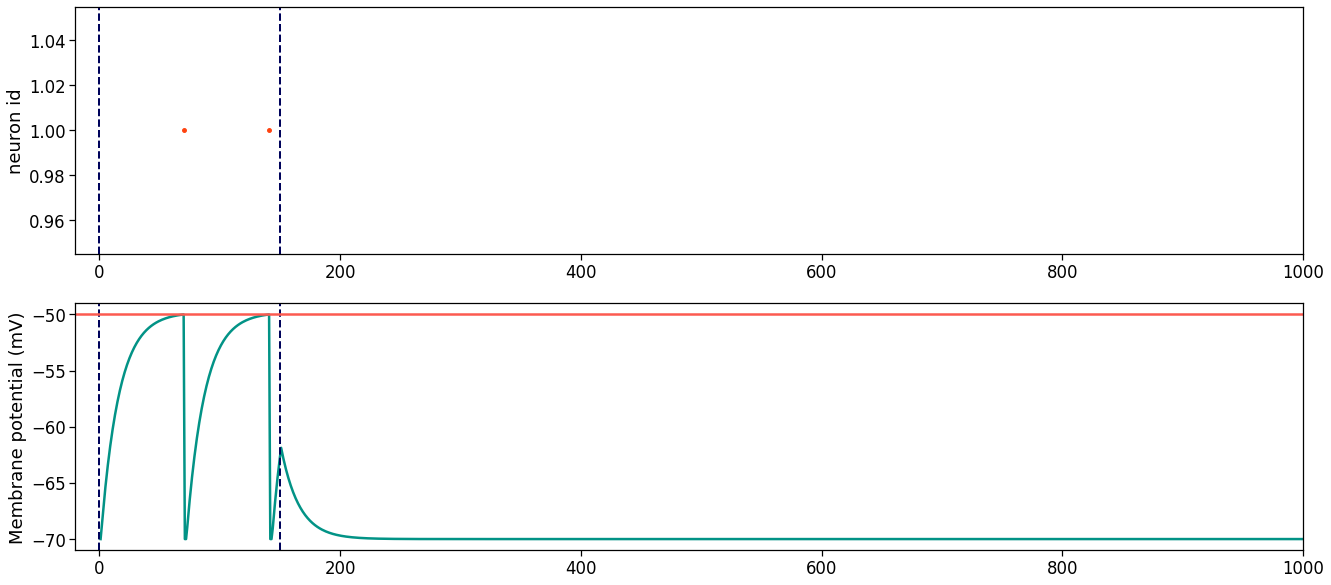

In [13]:
single_lif_neuron(337.34, 150., model_params)

## 2. What goes wrong with the dc generator if > 1 neuron?

- let's make a simple network with 5 neurons, where each neuron get's its own dc generator
- this should not influence the single neuron behaviour, but let's see what happens
- first make the function

**IDEA**: the problem is that even though each neuron has its own dc_generator, I am connecting ALL `dcgens` to ALL neurons! In the line

```
nest.Connect(dcgens, neuron_ids) # connect ALL dc_gens to ALL neurons
```

They will still stimulate all of the neurons, so of course they all spike!

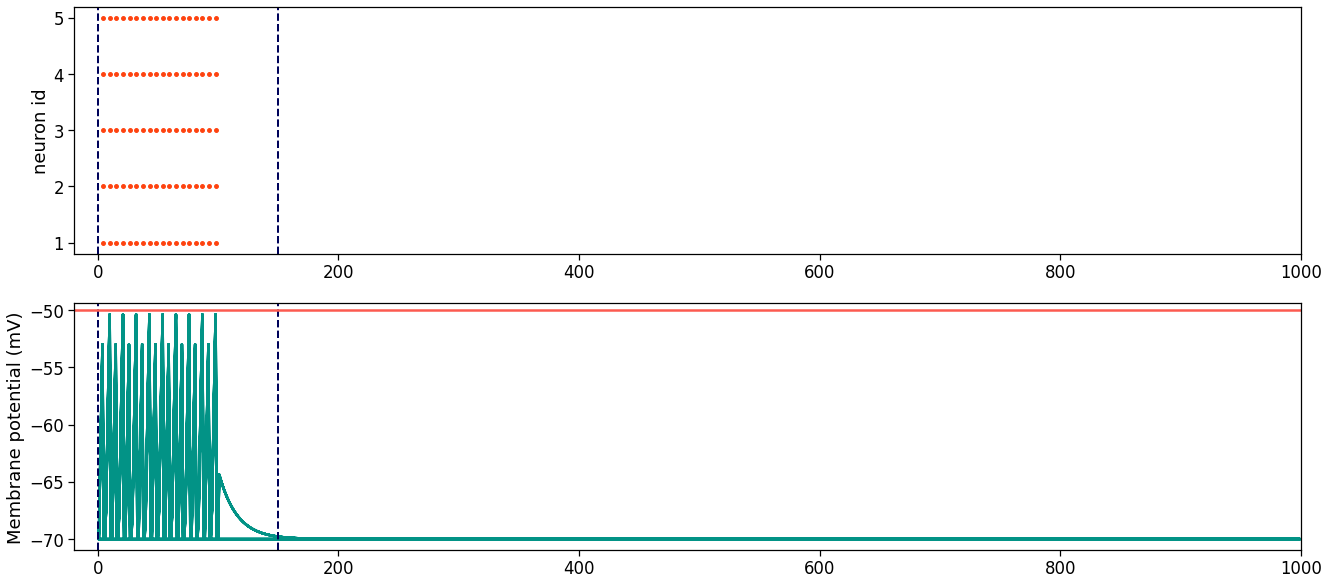

In [31]:
baby_network(150., model_params)

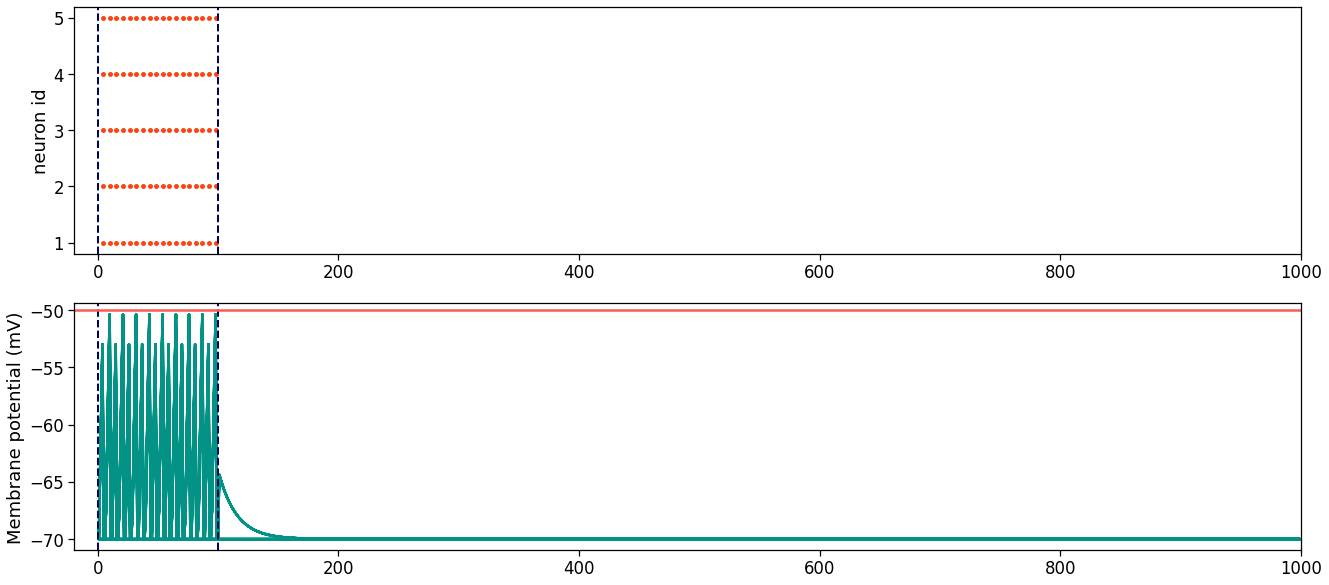

In [32]:
baby_network(100., model_params)

# Run the cells below first

In [2]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
# other
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
# horay for beautiful plots
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sim_params = {
        
        'N_total':1200,
        'NE': 960, # Default: 4/5 are exci neurons, 1/5 are inh neurons
        'NI': 240,
        'eps':0.1,  # connection probability
        'J_in':-96.0,
        'J_ex':6.0,
        'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
        'delay':1.5,  # synaptic delay in the network
        'n_threads':8,
        'stim_start':0., # start applying current (dc)
        'stim_end':100., # end applying current (dc)
        'simtime':1000., # simulation time 
        'sub_fr':0.9, # subthreshold current amplitude
        'sup_fr':1.01, # suprathreshold current amplitude
    }

model_params = {
        
        'C_m': 250.0,
        'E_L': -70.0,
        'E_ex': 0.0,
        'E_in': -80.0,
        'I_e': 0.0,
        'V_reset': -70.0,
        'V_th': -50.0,
        'g_L': 16.7,
        't_ref': 2.0, # Duration of refractory period
        'tau_syn_ex': 0.326, # Rise time of the excitatory synaptic alpha function
        'tau_syn_in': 0.326,
    }
    
syn_params_ex = {
    
        'model':'stdp_synapse',
        'lambda': 0.01,
        'alpha': 1.0,
        'delay': 1.5,
        'weight': 6.0,
        'Wmax': 100.0   
    }
    
syn_params_in = {
    
        'model':'stdp_synapse',
        'lambda': 0.01,
        'alpha': 1.0,
        'delay': 1.5,
        'weight':-95.0,
        'Wmax':-100.0  
    }

stim_amps = [300.6, 337.34]

In [5]:
def single_lif_neuron(amplitude, stim_end, model_params):
    nest.ResetKernel() 
    nest.SetKernelStatus({'resolution': 0.1, 'print_time': False, 'local_num_threads': 8})

    # ====== CREATE NEURONS =========
    neuron_ids = nest.Create('iaf_cond_alpha', 1, params=model_params)

    #  ====== CREATE & CONFIGURE GENERATORS + DETECTORS =========
    # create & configure dc generators (inputs)
    dcgen = nest.Create('dc_generator')
    nest.SetStatus(dcgen, {"amplitude": amplitude, "start": 0., "stop": stim_end})

    # create and configure spikedetector
    spikedet = nest.Create('spike_detector')
    nest.SetStatus(spikedet, params={"withgid": True, "withtime": True})

    # create and configure multimeter that records the voltage (V_m)
    multimet = nest.Create('multimeter', params={'record_from': ['V_m']})
    nest.SetStatus(multimet, params={'interval':1.})

    # ====== CONNECT TO DEVICES =========
    nest.Connect(neuron_ids, spikedet)
    nest.Connect(multimet, neuron_ids)
    nest.Connect(dcgen, neuron_ids)

    # ===== SIMULATE ======
    nest.Simulate(1000.)

    # ===== GET DATA ======
    spike_times = nest.GetStatus(spikedet, 'events')[0]['times']
    spike_neurons = nest.GetStatus(spikedet, 'events')[0]['senders']
    events = nest.GetStatus(multimet)[0]['events']
    etimes = events['times']
    
    # ==== PLOT ====
    fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))

    # raster plot
    ax1.scatter(spike_times, spike_neurons, marker='o', s=15, color='xkcd:orangered');
    ax1.set_ylabel('neuron id')
    ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.set_xlim([-20, 1000])

    # voltage
    ax2.plot(etimes, events['V_m'], color='xkcd:teal')
    ax2.set_ylabel('Membrane potential (mV)')
    ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
    ax2.set_xlim([-20, 1000]);

In [30]:
def baby_network(stim_end, model_params):
    
    N=5
    
    nest.ResetKernel() 
    nest.SetKernelStatus({'resolution': 0.1, 'print_time': False, 'local_num_threads': 8})

    # ====== CREATE NEURONS =========
    neuron_ids = nest.Create('iaf_cond_alpha', N, params=model_params)

    #  ====== CREATE & CONFIGURE GENERATORS + DETECTORS =========
    # create & configure 5 dc generators (inputs)
    nest.SetDefaults('dc_generator', {'start': 0., 'stop': 100.})
    dcgens = nest.Create('dc_generator', N)

    spikedet = nest.Create('spike_detector')
    nest.SetStatus(spikedet, params={"withgid": True, "withtime": True})

    multimet = nest.Create('multimeter', params={'record_from': ['V_m']})
    nest.SetStatus(multimet, params={'interval':1.})

    # ====== WIRE =========
    nest.Connect(neuron_ids, spikedet)
    nest.Connect(multimet, neuron_ids)
    nest.Connect(dcgens, neuron_ids) # connect ALL dc_gens to ALL neurons
    
    # ==== SET PATTERN =====
    pattern = [1,0,1,0,1] 
    stim_amps = [300.6, 337.34]

    for i in range(len(pattern)):

        stims_i = [int(x) for x in str(i)] 
        digit = pattern[i] # >>> 0 or 1
        nest.SetStatus( list(np.array(dcgens)[stims_i]), params={'amplitude': stim_amps[digit]} )

    # ===== SIMULATE ======
    nest.SetKernelStatus({'time':0.}) # turn back the clock
    nest.Simulate(1000.)

    # ===== GET DATA ======
    spike_times = nest.GetStatus(spikedet, 'events')[0]['times']
    spike_neurons = nest.GetStatus(spikedet, 'events')[0]['senders']
    events = nest.GetStatus(multimet)[0]['events']
    etimes = events['times']
    
    # ==== PLOT ====
    fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))

    # raster plot
    ax1.scatter(spike_times, spike_neurons, marker='o', s=15, color='xkcd:orangered');
    ax1.set_ylabel('neuron id')
    ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.set_xlim([-20, 1000])

    # voltage
    ax2.plot(etimes, events['V_m'], color='xkcd:teal')
    ax2.set_ylabel('Membrane potential (mV)')
    ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
    ax2.set_xlim([-20, 1000]);

In [6]:
# # ==== PLOT ====
# fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))

# # raster plot
# ax1.scatter(spike_times, spike_neurons, marker='o', s=10, color='k');
# ax1.set_ylabel('neuron id')
# ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
# ax1.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
# ax1.set_xlim([-20, 1000])

# # voltage
# ax2.plot(etimes, events['V_m'], color='xkcd:teal')
# ax2.set_ylabel('Membrane potential (mV)')
# ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
# ax2.axvline(x=100., linewidth=2., color='xkcd:dark blue', linestyle='--')
# ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
# ax2.set_xlim([-20, 1000]);

In [ ]:
# # ==== PLOT VM =====
# nest.voltage_trace.from_device(multimet)
# plt.axhline(y=-50.0, linewidth=2., color='xkcd:red', linestyle='--');